<a href="https://colab.research.google.com/github/LazBean/DRL_Escaper_v2/blob/main/DRL_Escaper_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install tensorflow-gpu==2.3.0
!pip install gym
!pip install keras
!pip install keras-rl2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320.4 MB 46 kB/s 
     |████████████████████████████████| 20.1 MB 1.4 MB/s 
     |████████████████████████████████| 2.9 MB 28.9 MB/s 
     |████████████████████████████████| 459 kB 41.5 MB/s 
     |████████████████████████████████| 26.1 MB 2.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 682 kB/s 
     |████████████████████████████████| 15.7 MB 9.5 MB/s 
     |████████████████████████████████| 438 kB 51.1 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflict

In [4]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import time

from IPython.display import clear_output

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKYELLOW = '\033[93m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    BGGREEN = '\033[;42m'
    BGRED = '\033[;41m'

In [5]:
class CustomEnv(Env):
  def __init__(self):
    
    self.observeRadius = 4

    self.action_space = Discrete(4)
    self.observation_space = self.observeRadius * 2-1

    self.minW = 5
    self.maxW = 20
    self.minH = 5
    self.maxH = 20

    self.max_time = 100

    self.maxEnemies = 8

    self.reset()


  def reset(self):
    self.d = 0
    self.time = 0
    self.done = False

    self.w = random.randint(self.minW, self.maxW-1)
    self.h = random.randint(self.minH, self.maxH-1)

    self.tiles = [[0 for x in range(self.w)] for y in range(self.h)] 

    self.player = [random.randint(0, self.w-1), random.randint(0, self.h-1)]

    self.door = [random.randint(0, self.w-1), random.randint(0, self.h-1)]

    self.enemiesCount = random.randint(1, self.maxEnemies-1)
    self.enemies = [] 

    for i in range(self.enemiesCount):
      self.enemies.append([random.randint(0, self.w-1), random.randint(0, self.h-1)])

    return self.state_creator()


  def step(self, action):

    self.time+=1
        
    # Move enemies towards player
    if(self.time%2==0):
      for i in range(self.enemiesCount):

        xd = (self.player[0] - self.enemies[i][0])
        yd = (self.player[1] - self.enemies[i][1])

        if( abs(xd)>abs(yd) ):
          self.enemies[i][0] += 1 * np.sign(xd)
        else:
          self.enemies[i][1] += 1 * np.sign(yd)
 

    reward = 0
    info = {"result": ""}
    # Giving Rewards according to conditions
    if(self.is_player_captured()):
      reward = -100
      self.done = True
      info["result"] = "Catch!"

    elif(self.is_out_of_bounds(self.player)):
      reward = -100
      self.done = True
      info["result"] = "Out!"

    elif(self.time >= self.max_time):
      reward = 0
      self.done = True
      info["result"] = "Time is over!"

    else:
      reward = -1

    # Player's move
    if(self.done == False):
      if(action == 0):
        self.player[1] +=1
      elif(action == 1):
        self.player[0] +=1
      elif(action == 2):
        self.player[1] -=1
      elif(action == 3):
        self.player[0] -=1

    # Counting distance to the Escape-Door
    xd = (self.player[0] - self.door[0])
    yd = (self.player[1] - self.door[1])
    self.d = abs(xd) + abs(yd)

    # WIN if reached the door
    if(self.player == self.door):
      reward = 100
      self.done = True
      info["result"] = "Escaped!"

    return self.state_creator(), reward, self.done, {}
  


  def render(self, mode='human', close=False):
    clear_output()
    boxGreen = bcolors.BGGREEN+' '+bcolors.ENDC
    boxRed = bcolors.BGRED+' '+bcolors.ENDC
    doorMark = bcolors.OKYELLOW+'O'+bcolors.ENDC

    for y in range(self.h):
      print("[", end = ' ')
      
      for x in range(self.w):
        s = " ,"
        yy = self.h-1 - y
        if([x,yy] == self.door):
          s = doorMark+","
        if([x,yy] == self.player):
          s = boxGreen+","
        for i in range(self.enemiesCount):
          if([x,yy] == self.enemies[i]):
            s = boxRed+","
            break
        
        print(s, end = ' ')
        
      print("]")  
    print("step: {}, door: {}, pos: {} - distance: {}".format(self.time, self.door, self.player, self.d))  
    print("\nInput Data:\n"+str(env.state_creator()))
    time.sleep(1)
      

  def is_player_captured(self):
    for i in range(self.enemiesCount):
      if(self.player == self.enemies[i]):
        return True
    return False


  def is_out_of_bounds(self, pos):
    return (pos[0] < 0) or (pos[1] < 0) or (pos[0] >= self.w) or (pos[1] >= self.h)


  def state_creator(self):
    r = self.observeRadius
    state = []
    
    for y in range(self.player[1]+1 - r, self.player[1] + r):
      row = []
      yy = y
      for x in range(self.player[0]+1 - r, self.player[0] + r):
        v = 0
        if(self.is_out_of_bounds([x,yy])):
          v = -1
        else:
          if([x,yy] == self.door):
            v = 2
          if([x,yy] == self.player):
            v = self.d #1
          for i in range(self.enemiesCount):
            if([x,yy] == self.enemies[i]):
              v = -2
              break
        
        row.append(v)
      state.append(row)

    a = np.array(state)
    return a

In [6]:
env = CustomEnv()

In [26]:
env.state_creator()

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [ ]:
# Testing environment
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{} {}'.format(episode, score, info))

# **2. Create a Deep Learning Model with Keras**

In [8]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:513: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool,
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/tensor_util.py:107: DeprecationWarning: `np.object` is a deprecated ali

In [9]:
states = env.observation_space#env.observation_space.shape[0]
actions = env.action_space.n

def build_model(states, actions):
    model = Sequential()    
    model.add(Dense(24, activation='relu', input_shape=(1, states, states,))) # input_dim=states
    model.add(Dense(24, activation='relu'))
    model.add(Flatten())
    model.add(Dense(actions, activation='linear'))
    return model

In [16]:
# In case of model compilation error
del model

In [17]:
model = build_model(states, actions)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1, 7, 24)          192       
_________________________________________________________________
dense_7 (Dense)              (None, 1, 7, 24)          600       
_________________________________________________________________
flatten_2 (Flatten)          (None, 168)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 676       
Total params: 1,468
Trainable params: 1,468
Non-trainable params: 0
_________________________________________________________________


# **3. Build Agent with Keras-RL**

In [13]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [18]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [19]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
history = dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_utils.py:1446: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(sample_weight_mode, collections.Mapping):
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Training for 50000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 14:36 - reward: -1.0000

/usr/local/lib/python3.7/dist-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/usr/local/lib/python3.7/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)


   29/10000 [..............................] - ETA: 4:09 - reward: -7.7586

/usr/local/lib/python3.7/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 13 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.7/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 14 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.7/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 15 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.7/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 16 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.7/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 17 + 1) instead
  batch_idxs

10000/10000 [==============================] - 98s 10ms/step - reward: -2.8065
635 episodes - episode_reward: -44.118 [-189.000, 100.000] - loss: 179.743 - mae: 36.283 - mean_q: -26.111

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 97s 10ms/step - reward: -0.1120
580 episodes - episode_reward: -1.945 [-199.000, 100.000] - loss: 212.591 - mae: 30.115 - mean_q: -1.834

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 103s 10ms/step - reward: 0.7256
556 episodes - episode_reward: 13.005 [-175.000, 100.000] - loss: 208.101 - mae: 28.366 - mean_q: 6.727

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 98s 10ms/step - reward: 0.2602
502 episodes - episode_reward: 5.309 [-181.000, 100.000] - loss: 197.965 - mae: 27.328 - mean_q: 13.376

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 103s 10ms/step - reward: 1.0911
done, took 499.541 seconds


In [24]:
_ = dqn.test(env, nb_episodes=1, visualize=True)

[  ,  ,  ,  ,  ,  ,  , ]
[  ,  ,  ,  ,  ,  ,  , ]
[  ,  ,  ,  ,  ,  ,  , ]
[  ,  ,  ,  ,  ,  ,  , ]
[  ,  ,  ,  ,  ,  ,  , ]
[  ,  ,  ,  ,  ,  ,  , ]
[  ,  ,  ,  ,  ,  ,  , ]
[  ,  ,  ,  ,  ,  ,  , ]
step: 7, door: [0, 1], pos: [0, 1] - distance: 0

Input Data:
[[-1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1  0  0  0  0]
 [-1 -1 -1  0  0  0 -2]
 [-1 -1 -1  0  0  0 -2]
 [-1 -1 -1  0 -2  0  0]
 [-1 -1 -1  0  0  0  0]]
Episode 1: reward: 94.000, steps: 7


# **4. Reloading Agent from Memory**

In [21]:
dqn.save_weights('dqn_weights.h5f', overwrite=True)

In [ ]:
env = CustomEnv()
actions = env.action_space.n
states = env.observation_space
model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [ ]:
dqn.load_weights('dqn_weights.h5f')

In [80]:
_ = dqn.test(env, nb_episodes=1, visualize=True)

[  ,  ,  ,  ,  , O,  ,  ,  ,  ,  ,  ,  ,  ,  , ]
[  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  , ]
[  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  , ]
[  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  , ]
[  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  , ]
[  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  , ]
step: 14, door: [5, 5], pos: [3, 2] - distance: 5

Input Data:
[[-1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0]
 [ 0  0 -2  0  0 -2  0]
 [ 0  0  0 -2  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0]]
Episode 1: reward: -113.000, steps: 14


In [78]:
scores = dqn.test(env, nb_episodes=100, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 100 episodes ...
Episode 1: reward: 55.000, steps: 46
Episode 2: reward: 19.000, steps: 82
Episode 3: reward: 87.000, steps: 14
Episode 4: reward: -109.000, steps: 10
Episode 5: reward: 93.000, steps: 8
Episode 6: reward: 60.000, steps: 41
Episode 7: reward: 75.000, steps: 26
Episode 8: reward: 74.000, steps: 27
Episode 9: reward: -105.000, steps: 6
Episode 10: reward: 94.000, steps: 7
Episode 11: reward: 32.000, steps: 69
Episode 12: reward: 90.000, steps: 11
Episode 13: reward: 98.000, steps: 3
Episode 14: reward: -101.000, steps: 2
Episode 15: reward: 94.000, steps: 7
Episode 16: reward: 81.000, steps: 20
Episode 17: reward: 90.000, steps: 11
Episode 18: reward: 82.000, steps: 19
Episode 19: reward: 78.000, steps: 23
Episode 20: reward: 62.000, steps: 39
Episode 21: reward: -139.000, steps: 40
Episode 22: reward: 73.000, steps: 28
Episode 23: reward: 54.000, steps: 47
Episode 24: reward: 71.000, steps: 30
Episode 25: reward: -107.000, steps: 8
Episode 26: reward: -104.00

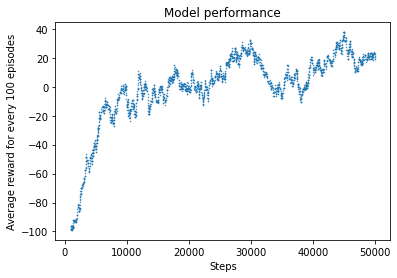

In [75]:
import plotly.graph_objs as go
from matplotlib import pyplot as plt
import pandas as pd


l = 100

df = pd.DataFrame (history.history['episode_reward'], columns = ['column_name'])
df = df.rolling(window=l).mean()

X = np.array(history.history['nb_steps'])

plt.title('Model performance')
plt.ylabel('Average reward for every {} episodes'.format(l))
plt.xlabel('Steps')

#plt.plot(df)
plt.scatter(X,df, s=0.2)
plt.show()